<img style="display: block;-webkit-user-select: none;margin: auto;cursor: zoom-out;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://www.udea.edu.co/wps/wcm/connect/udea/721b156e-f6bc-4dc8-8595-8b4731c9a8c7/facultad-ingenieria.png?MOD=AJPERES&amp;CVID=nc5CqsS" width="450">

**SISTEMAS DE CONTROL CONTÍNUO**

- Universidad de Antioquia
- 20251

# Modeling First Order plus Time Delay Systems Using Optimization approaches

## Task

Linear first order plus time delay (FOPTD) models are often good approximations to process dynamics for process control applications. This notebook demonstrates the fitting of FOPTD models to step response data.

## Initializations

In [ ]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
from scipy.optimize import minimize

## First Order plus Time Delay Models

### First Order Models

A linear first-order plus time-delay model is a good approximation for many process control applications. Assume the manipulated process input, $u$, and measured process output, $y$, are initially at steady-state $u_0, y_0$.  

Without loss of generality, the response of a linear first-order system without time-delay can be written as a differential equation

$$\tau\frac{d(y-y_0)}{dt} + (y-y_0) = K(u-u_0)$$

or

$$\tau\frac{dy}{dt} + (y-y_0) = K(u-u_0)$$

At time $t_0$, the input $u$ is changed to a new constant value $u_\infty$. Provided the system is stable (i.e, $\tau \geq 0$), the new steady state value of $y$ will be

$$y_\infty = y_0 + K(u_\infty - u_0)$$


The solution to the differential equation can be written in a number of useful forms.

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-t_0)/\tau)}
\end{align*}

### Time Delay

Chemical processes are frequently encumbered with time delays associated with the transport of materials, chemical measurement, or simply sluggish response to control inputs. A pure time delay is modeled by a single parameter, $\tau_d$, such that

$$y(t) = u(t-\tau_d)$$

### First Order plus Time Delay (FOPTD)

If we add the time delay feature to the first order process described above, then

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-\tau_d - t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-\tau_d-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-\tau_d-t_0)/\tau)}
\end{align*}

### Visualization

First we write a function to compute the response of a first order system with time delay to a unit step input where $u_0 = 0$ and $u_\infty = 1$.  

In [ ]:
def foptd(t, K=1, tau=1, tau_d=0):
    tau_d = max(0,tau_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-tau_d)/tau)) if t >= tau_d else 0 for t in t])

Text(0.5, 1.0, 'FOPTD Step Response')

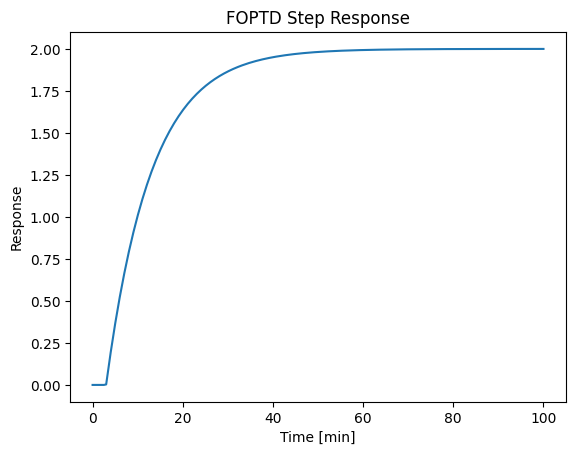

In [ ]:
t = np.linspace(0,100,200)
tau = 10
tau_delay = 3
K = 2

y = foptd(t,K,tau,tau_delay)
plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('Response')
plt.title('FOPTD Step Response')

## Fitting an FOPTD model

### Sample Problem Statement

A distillation column is initially at steady state where the cooling water flow to the condensor is 110 kg/hr and the vapor phase mole fraction of the volatile compound is 0.87.  At t = 60 min, the steam flow is raised to 120 kg/hr. The vapor phase mole fraction increases as shown in the following chart.

The problem task to fit a FOPTD model to this experimental result.

Text(0.5, 1.0, 'Vapor mole fraction response to 10 kg/hr increase in condensor coolng')

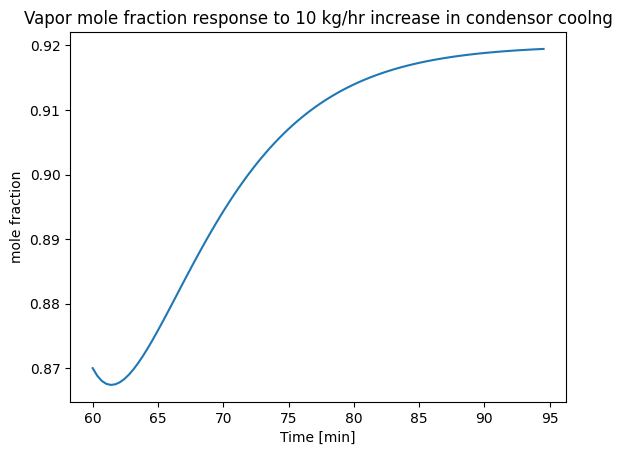

In [ ]:
# create the hypothetical problem data
t, delta_y = control.step_response(0.05*control.tf([-2, 1],[25, 10, 1])) # simulated process
y = 0.87 + delta_y
t = t + 60

plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('mole fraction')
plt.title('Vapor mole fraction response to 10 kg/hr increase in condensor coolng')

### Step 1. Shift and scale the experimental data to correspond to a unit step input at time t =  0.

The first step is to scale the experimental data to fit the framework of an FOPTD model. This generally involves three steps:

* Shift the time scale to t = 0 corresponds to the start of the experiment.

$$ t_s = t - t_0$$

* Shift the response so y = 0 is the initial steady state
* Rescale the response to a unit change in input

$$ y_s = \frac{y(t) - y_0}{u_\infty - u_0}$$

Text(0.5, 1.0, 'Shifted and Scaled Data')

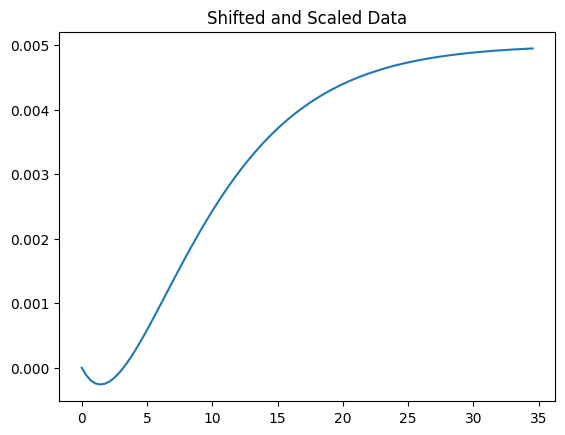

In [ ]:
ts = t - t[0]
ys = (y - y[0])/(120 - 110)

plt.plot(ts, ys)
plt.title('Shifted and Scaled Data')

### Step 2. Create a function to compute the response of an FOPTD model.

For a given list of times $t$ and parameters $K$, $\tau$, and $\tau_d$, the `foptd` returns the response of an FOPTD system to a unit change in input at $t = 0$.

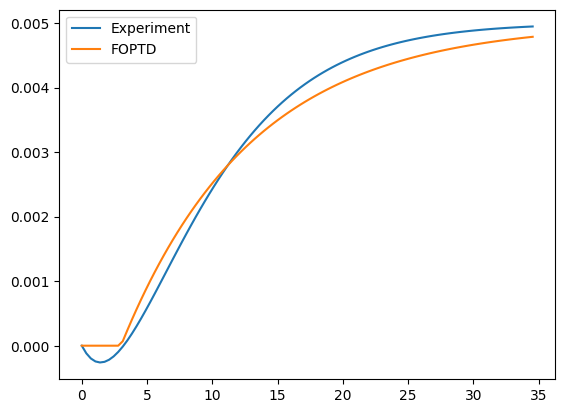

In [ ]:
def foptd(t, K=1, tau=1, tau_d=0):
    tau_d = max(0,tau_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-tau_d)/tau)) if t >= tau_d else 0 for t in t])

z = foptd(ts, 0.005, 10, 3)
plt.plot(ts,ys,ts,z)
plt.legend(['Experiment','FOPTD'])

### Step 3. Create a function to measure the error between an FOPTD model and the experimental data.

Let's called the step response of the fitted model to be $\hat{y}_s$. We seek to minimize

$$\min_{K,\tau,\tau_d} \int_0^T \|\hat{y}_s - y_s\|\,dt$$

for some suitable norm $\|\cdot\|$.  A common choice of norm for process control is the absolute value of the difference called Integral Absolute Error (IAE)

$$\text{IAE} = \min_{K,\tau,\tau_d} \int_0^T |\hat{y}_s - y_s|\,dt$$

The advantage of IAE over other choices of norms is that it tends to be more robust with respect to larger errors.

In [ ]:
def err(X,t,y):
    K,tau,tau_d = X
    z = foptd(t,K,tau,tau_d)
    iae = sum(abs(z-y))*(max(t)-min(t))/len(t)
    return iae

X = [0.005,10,3]
err(X,ts,ys)

np.float64(0.007690409406960637)

### Step 4. Use scipy.optimize.minimize() to find the best fitting FOPTD model.

In [ ]:
K,tau,tau_d = minimize(err,X,args=(ts,ys)).x

print("K = {:.5f}".format(K))
print("tau = {:.2f}".format(tau))
print("tau_d = {:.2f}".format(tau_d))

K = 0.00512
tau = 8.08
tau_d = 4.58


### Step 5. Rescale FOPTD output and compare to experimental data.

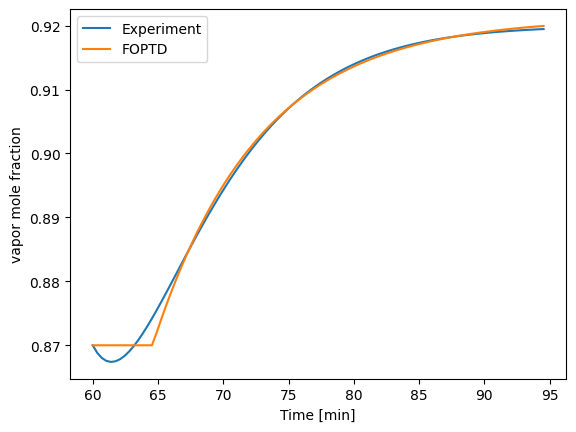

In [ ]:
z = foptd(ts,K,tau,tau_d)
ypred = y[0] + z*(120 - 110)

plt.plot(t,y,t,ypred)
plt.xlabel('Time [min]')
plt.ylabel('vapor mole fraction')
plt.legend(['Experiment','FOPTD'])

This notebook is a modified versión of the
- Jeffrey Kantor (jeff at nd.edu)
- The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

## Modelado Datos Reales Plantas

Este sistema estima los parámetros de la función de transferencia para un sistema de orden 1 con tiempo muerto

$$ G(s) = \frac{K e^{t_m s}}{\tau s + 1} $$

In [ ]:
!gdown '1OWR5m3cDoDUMjBdXvRXDpgyM4b57HOP1' -O 'datosPlanta.txt'

Downloading...
From: https://drive.google.com/uc?id=1OWR5m3cDoDUMjBdXvRXDpgyM4b57HOP1
To: /content/datosPlanta.txt
100% 20.9k/20.9k [00:00<00:00, 43.3MB/s]


In [ ]:
import pandas as pd

In [ ]:
datosPlanta = pd.read_csv('datosPlanta.txt', sep=",", header=0)

In [ ]:
datosPlanta.head()

,Tiempo (s),T1 (C),T2 (C),PWM_Heater1,PWM_Heater2
0,0.01,24.93,22.97,0,0
1,1.04,24.93,22.97,0,0
2,2.04,25.42,22.97,0,0
3,3.04,24.93,22.97,0,0
4,4.04,24.44,23.46,0,0


<Axes: >

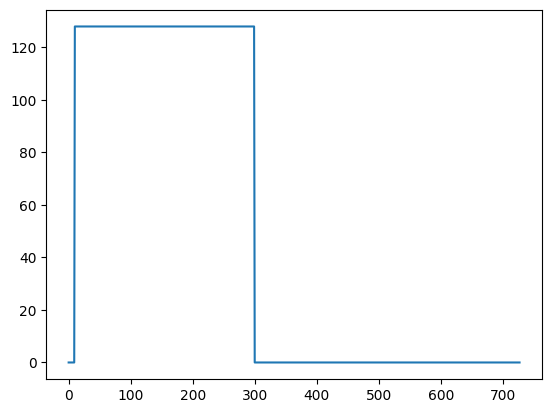

In [ ]:
datosPlanta[' PWM_Heater1'].plot()

In [ ]:
import pandas as pd

Generalemnte los datos reales vienen con ruido

In [ ]:
y = datosPlanta[' T1 (C)'].values
y = y[10:300]
u = datosPlanta[' PWM_Heater1'].values
u = u[10:300]
tiempo = datosPlanta['Tiempo (s)'].values
tiempo = tiempo[10:300]

In [ ]:
from scipy.signal import savgol_filter
n = 7          # window length
polyorder = 3  # cubic polinomial approximation
heater1 = y
smooth_heater1 = savgol_filter(heater1, n, polyorder, mode='nearest')

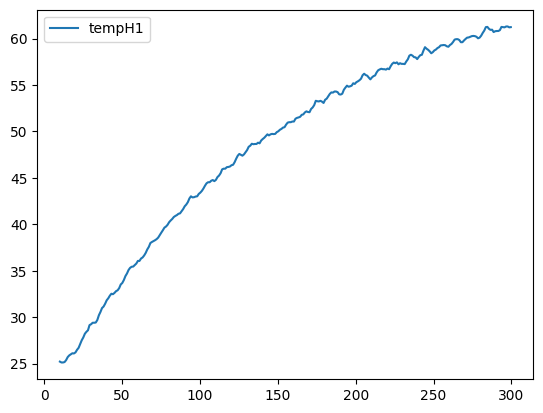

In [ ]:
plt.plot(tiempo,smooth_heater1,label= 'tempH1')
plt.legend()
plt.show()

In [ ]:
print(u[:20])

[  0   0   0   0   0   0   0   0   0   0 128 128 128 128 128 128 128 128
 128 128]


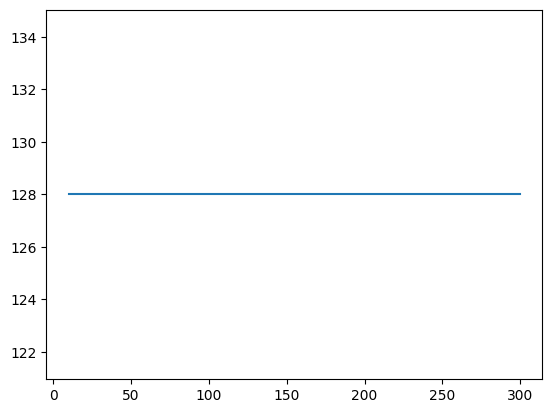

In [ ]:
plt.plot(tiempo,u,label= 'pwmH1')
plt.show()

Text(0.5, 1.0, 'Shifted and Scaled Data')

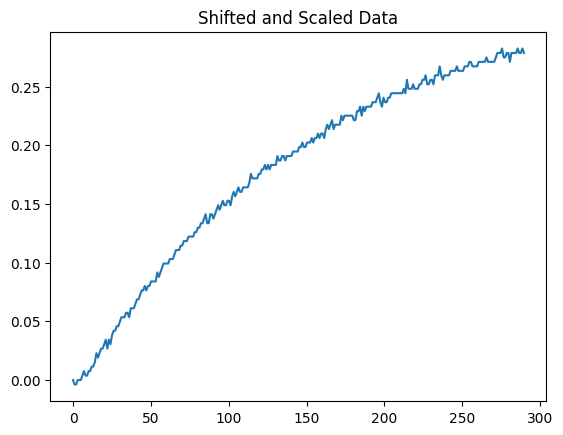

In [ ]:
t = tiempo.copy()
y = y.copy()
ts = t - t[0]
ys = (y - y[0])/(128 - 0)

plt.plot(ts, ys)
plt.title('Shifted and Scaled Data')

In [ ]:
X = [0.5,20,2]
K,tau,tau_d = minimize(err,X,args=(ts,ys)).x

print("K = {:.5f}".format(K))
print("tau = {:.2f}".format(tau))
print("tau_d = {:.2f}".format(tau_d))

K = 0.33148
tau = 151.46
tau_d = 6.30


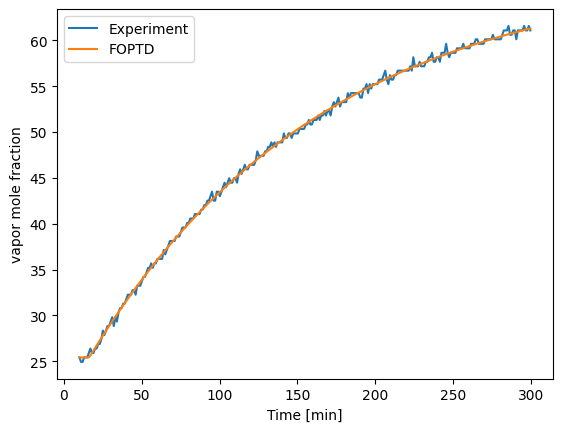

In [ ]:
z = foptd(ts,K,np.abs(tau),tau_d)
ypred = y[0] + z*(128 - 0)

plt.plot(t,y,t,ypred)
plt.xlabel('Time [min]')
plt.ylabel('vapor mole fraction')
plt.legend(['Experiment','FOPTD'])

In [ ]:
(150*5)/60

12.5